# DMRG for a local Hamiltonian
(see also https://www.tensors.net/p-dmrg)
This is meant to be a pedagogical implementation of a 2 sites DMRG algorithm for the Ising model in transverse field 
We first define the Hamiltonian as a list of $N$ two body terms that depends on $g$ 
$$H = \sum_{i=0}^{N-2} \left[\sigma_x^i \sigma_x ^{i+1}+ \frac{g}{2}(\sigma_z^i +\sigma_z^{i+1})\right] + \frac{g}{2}\sigma_z^0+\frac{g}{2}\sigma_z^{N-1}  $$

Notice that they are all the same but the first and last. 

We also initialiaze the MPS to a list of random complex tensor with an initial uniform  bond dimension $\chi$
Our indexing conventions for MPS in the left canonical,  and MPS in right canonical:
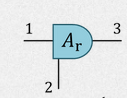

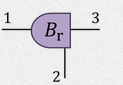

The hamiltonian is 
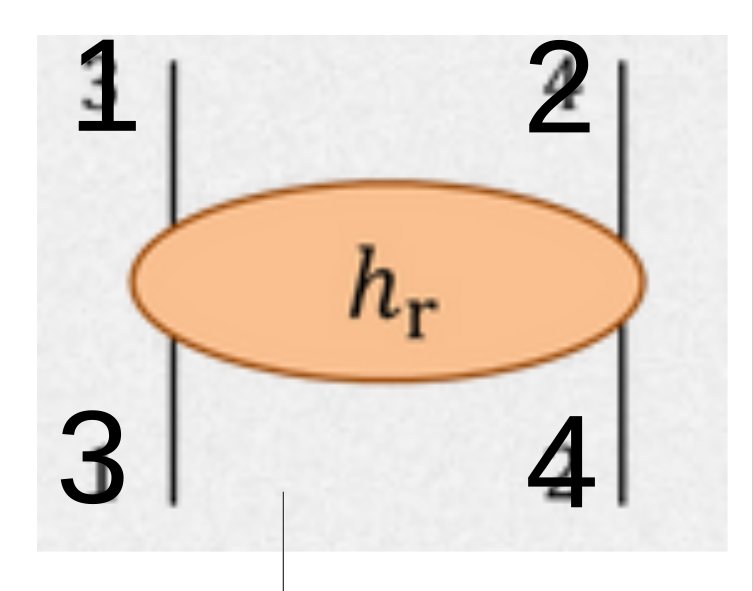


In [1]:
import numpy as np
import scipy.linalg as LA
from scipy.sparse.linalg import LinearOperator,eigs
from functools import partial
from ncon import ncon

sigma_x = np.array([[0.,1],[1,0]])
sigma_z =  np.array([[1,0.],[0,-1]])
identity =  np.array([[1,0.],[0,1]])
N=10
g=0.5
d=2
chi = 2
chi_max =20
h_loc =np.kron(sigma_x,sigma_x).reshape(2,2,2,2)+g*0.5*(np.kron(sigma_z,identity).reshape(2,2,2,2)+
                                                        np.kron(identity,sigma_z).reshape(2,2,2,2))

list_ham =[]
list_ham.append(h_loc+g*0.5*np.kron(identity,sigma_z).reshape(2,2,2,2))
list_A =[]
list_A.append(np.random.rand(1,d,chi)+1j*np.random.rand(1,d,chi))

for k in range(1,N-1):
    list_ham.append(h_loc)
    list_A.append(np.random.rand(chi,d,chi)+1j*np.random.rand(chi,d,chi))

list_ham.append(h_loc+g*0.5*(np.kron(sigma_z,identity).reshape(2,2,2,2)))
list_A.append(np.random.rand(chi,d,1)+1j*np.random.rand(chi,d,1))

Now we can start preparing the left sweep, remember that we need to 
1. go to the correct left canonical gauge in order to normalize the state
2. start accumulating the left effective Hamiltonian 
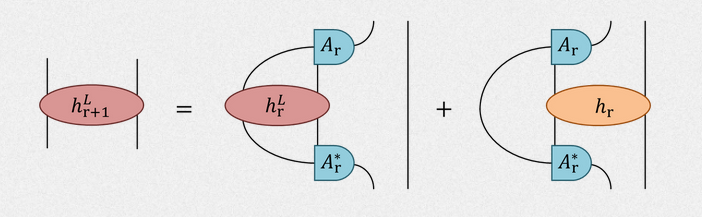    

In [2]:
H_left=[]
H_left.append(np.zeros((2,2)).reshape(1,2,1,2))
for k in range(N-1):
    chi_l =list_A[k].shape[0]
    chi_r =list_A[k].shape[2]

    list_A[k], sa, VAd =LA.svd(list_A[k].reshape(chi_l*d,chi_r),full_matrices=False)
    list_A[k] = list_A[k].reshape(chi_l,d,len(sa))
    list_A[k+1] = (1./LA.norm(sa)*np.diag(sa)@VAd@list_A[k+1].reshape(list_A[k+1].shape[0],(
                                                   list_A[k+1].shape[1]*list_A[k+1].shape[2]))).reshape(
    len(sa),list_A[k+1].shape[1],list_A[k+1].shape[2])
    #list_A[1] = list_A[1].reshape(orig_shape)
    H_left.append(ncon([list_A[k], list_A[k].conj(), H_left[k], identity],
                       [[1,2,-1],  [ 3,4,-3],        [1,2,3,4], [-2,-4]])+
                  ncon([list_A[k], list_A[k].conj(), list_ham[k]],
                       [[1,2,-1],  [1,3,-3],         [2,-2,3,-4]]))

#We now nomrmalize the last site
chi_l =list_A[N-1].shape[0]
chi_r =list_A[N-1].shape[2]
list_A[N-1],_ =LA.qr(list_A[N-1].reshape(chi_l*d,chi_r), mode='economic')
list_A[N-1] = list_A[N-1].reshape(chi_l,d,chi_r)

We now can start the optimization, remember that we perform the first sweep from the right, we need to
1. compute the right effective Hamiltonian
2. sum it to the the local contribution and the left effective Hamiltonian to get the effective Hamiltonian 
3. find the lowest eigenvector of such effective Hamiltonian 
4. peform and svd of the eigenvector obtain and update the two matrices, then move one site to the right to restart the procedure

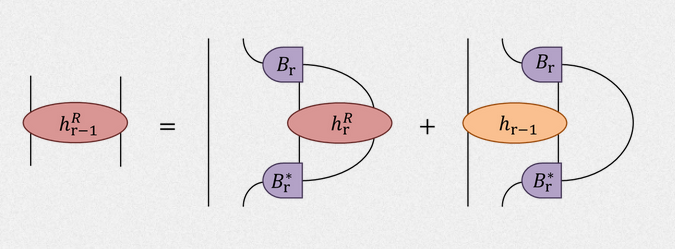


In [3]:

H_right = [0 for x in range(N)]
H_right[N-1]=np.zeros((2,2)).reshape(2,1,2,1)
def mult_vet_eff_h(v0,h_l,h,h_r):
    cl = h_l.shape[0]
    cd = h_l.shape[1]
    cr = h_r.shape[1]
    v0_t = v0.reshape(cl,d,d,cr)
    #The effective Hamiltonian has 3 components
    v1 = (ncon([v0_t,h_l],[[1,2,-3,-4],[1,2,-1,-2]])+
          ncon([v0_t,h],[[-1,1,2,-4],[1,2,-2,-3]])+
          ncon([v0_t,h_r],[[-1,-2,1,2],[1,2,-3,-4]]))
    return v1.reshape(v0.shape)
 
for k in range(N-2,-1,-1):
    chil = list_A[k].shape[0]
    chir = list_A[k+1].shape[2]
    init_state = ncon([list_A[k],list_A[k+1]],[[-1,-2,1],[1,-3,-4]]).reshape(chil*d*d*chir)
    matvec_partial = partial(mult_vet_eff_h, h_l=H_left[k], h=list_ham[k],h_r=H_right[k+1])
    #Here we compute the lowest eigenvector of the effective Hamiltonian 
    ene_t, g_state= eigs(LinearOperator((chil*d*d*chir, chil*d*d*chir), matvec=matvec_partial),
                         k=1, which='SR', v0=init_state, tol=1e-10)
    print('After optimizing link %d we get Energy: %f'%(k,np.real_if_close(ene_t))) 
    U_g, s_g, vd_g = LA.svd(g_state.reshape(chil*d,d*chir), full_matrices=False)
    chitemp = min(len(s_g),chi_max)   
    list_A[k] = (U_g@np.diag(s_g))[:,range(chitemp)].reshape(chil,d,chitemp)/LA.norm(s_g[range(chitemp)])
    list_A[k+1] = vd_g[range(chitemp),:].reshape(chitemp,d,chir)
    H_right[k] = (ncon([list_A[k+1], list_A[k+1].conj(), H_right[k+1],identity],
                      [[-2,2,1],   [-4,3,4],        [2,1,3,4], [-1,-3]])+
                  ncon([list_A[k+1], list_A[k+1].conj(),list_ham[k]],
                        [[-2,1,2], [-4,3,2],[-1,1,-3,3]]))

After optimizing link 8 we get Energy: 1.389729
After optimizing link 7 we get Energy: -0.568571
After optimizing link 6 we get Energy: -2.230831
After optimizing link 5 we get Energy: -4.005104
After optimizing link 4 we get Energy: -5.692362
After optimizing link 3 we get Energy: -7.388813
After optimizing link 2 we get Energy: -9.127429
After optimizing link 1 we get Energy: -9.251140
After optimizing link 0 we get Energy: -9.251140


Now we perform a left sweep that is the same than the right but in the other direction 

In [4]:
chi_l =list_A[0].shape[0]
chi_r =list_A[0].shape[2]
list_A[0], sa, VAd =LA.svd(list_A[0].reshape(chi_l*d,chi_r),full_matrices=False)
list_A[0] = list_A[k].reshape(chi_l,d,len(sa))
list_A[1] = (1./LA.norm(sa)*np.diag(sa)@VAd@list_A[1].reshape(list_A[1].shape[0],(
                                                   list_A[1].shape[1]*list_A[1].shape[2]))).reshape(
    len(sa),list_A[1].shape[1],list_A[1].shape[2])
for k  in range(N-1):
    chil = list_A[k].shape[0]
    chir = list_A[k+1].shape[2]
    init_state = ncon([list_A[k],list_A[k+1]],[[-1,-2,1],[1,-3,-4]]).reshape(chil*d*d*chir)
    matvec_partial = partial(mult_vet_eff_h, h_l=H_left[k], h=list_ham[k],h_r=H_right[k+1])
    ene_t, g_state= eigs(LinearOperator((chil*d*d*chir, chil*d*d*chir), matvec=matvec_partial),
                         k=1, which='SR', v0=init_state, tol=1e-10)
    print('After optimizing link %d we get Energy: %f'%(k,np.real_if_close(ene_t))) 
    U_g, s_g, vd_g = LA.svd(g_state.reshape(chil*d,d*chir), full_matrices=False)
    chitemp = min(len(s_g),chi_max) 
    list_A[k] = U_g.reshape(chil,d,chitemp)
    list_A[k+1] = (np.diag(s_g[0:chitemp])@vd_g[0:chitemp,:]).reshape(chitemp,d,chir)
    H_left[k+1]=(ncon([list_A[k], list_A[k].conj(), H_left[k], identity],
                       [[1,2,-1],  [ 3,4,-3],        [1,2,3,4], [-2,-4]])+
                  ncon([list_A[k], list_A[k].conj(), list_ham[k]],
                       [[1,2,-1],  [1,3,-3],         [2,-2,3,-4]]))

After optimizing link 0 we get Energy: -9.251140
After optimizing link 1 we get Energy: -9.251140
After optimizing link 2 we get Energy: -9.273231
After optimizing link 3 we get Energy: -9.460245
After optimizing link 4 we get Energy: -9.577703
After optimizing link 5 we get Energy: -9.654491
After optimizing link 6 we get Energy: -9.654701
After optimizing link 7 we get Energy: -9.654701
After optimizing link 8 we get Energy: -9.654701


Now we have performed the 2 basics sweeps we just need to put it all in nice functions and repeat for an arbitrary number of sweeps. 

In [5]:
def do_dmrg(list_A,list_ham,chi_max,nsweep):
    def mult_vet_eff_h(v0,h_l,h,h_r):
        cl = h_l.shape[0]
        cd = h_l.shape[1]
        cr = h_r.shape[1]
        v0_t = v0.reshape(cl,d,d,cr)
        #The effective Hamiltonian has 3 components
        v1 = (ncon([v0_t,h_l],[[1,2,-3,-4],[1,2,-1,-2]])+
              ncon([v0_t,h],[[-1,1,2,-4],[1,2,-2,-3]])+
              ncon([v0_t,h_r],[[-1,-2,1,2],[1,2,-3,-4]]))
        v1.reshape(v0.shape)
        return v1

    N=len(list_A)
    H_left=[]
    H_left.append(np.zeros((2,2)).reshape(1,2,1,2))
    for k in range(N-1):
        chi_l =list_A[k].shape[0]
        chi_r =list_A[k].shape[2]

        list_A[k], sa, VAd =LA.svd(list_A[k].reshape(chi_l*d,chi_r),full_matrices=False)
        list_A[k] = list_A[k].reshape(chi_l,d,len(sa))
        list_A[k+1] = (1./LA.norm(sa)*np.diag(sa)@VAd@list_A[k+1].reshape(list_A[k+1].shape[0],(
                                                       list_A[k+1].shape[1]*list_A[k+1].shape[2]))).reshape(
        len(sa),list_A[k+1].shape[1],list_A[k+1].shape[2])
        #list_A[1] = list_A[1].reshape(orig_shape)
        H_left.append(ncon([list_A[k], list_A[k].conj(), H_left[k], identity],
                           [[1,2,-1],  [ 3,4,-3],        [1,2,3,4], [-2,-4]])+
                      ncon([list_A[k], list_A[k].conj(), list_ham[k]],
                           [[1,2,-1],  [1,3,-3],         [2,-2,3,-4]]))

    #We now nomrmalize the last site
    chi_l =list_A[N-1].shape[0]
    chi_r =list_A[N-1].shape[2]
    list_A[N-1],_ =LA.qr(list_A[N-1].reshape(chi_l*d,chi_r), mode='economic')
    list_A[N-1] = list_A[N-1].reshape(chi_l,d,chi_r)
    for n_s in range(nsweep):
    #We start the right to left optimization sweep 
        H_right = [0 for x in range(N)]
        H_right[N-1]=np.zeros((2,2)).reshape(2,1,2,1)
        for k in range(N-2,-1,-1):
            chil = list_A[k].shape[0]
            chir = list_A[k+1].shape[2]
            init_state = ncon([list_A[k],list_A[k+1]],[[-1,-2,1],[1,-3,-4]]).reshape(chil*d*d*chir)
            matvec_partial = partial(mult_vet_eff_h, h_l=H_left[k], h=list_ham[k],h_r=H_right[k+1])
            #Here we compute the lowest eigenvector of the effective Hamiltonian 
            ene_t, g_state= eigs(LinearOperator((chil*d*d*chir, chil*d*d*chir), matvec=matvec_partial),
                                 k=1, which='SR', v0=init_state, tol=1e-10)
            #print('After optimizing link %d we get Energy: %f'%(k,np.real_if_close(ene_t))) 
            U_g, s_g, vd_g = LA.svd(g_state.reshape(chil*d,d*chir), full_matrices=False)
            chitemp = min(len(s_g),chi_max)   
            list_A[k] = (U_g@np.diag(s_g))[:,range(chitemp)].reshape(chil,d,chitemp)/LA.norm(s_g[range(chitemp)])
            list_A[k+1] = vd_g[range(chitemp),:].reshape(chitemp,d,chir)
            H_right[k] = (ncon([list_A[k+1], list_A[k+1].conj(), H_right[k+1],identity],
                              [[-2,2,1],   [-4,3,4],        [2,1,3,4], [-1,-3]])+
                          ncon([list_A[k+1], list_A[k+1].conj(),list_ham[k]],
                                [[-2,1,2], [-4,3,2],[-1,1,-3,3]]))
        #We normalize first site
        chi_l =list_A[0].shape[0]
        chi_r =list_A[0].shape[2]
        list_A[0], sa, VAd =LA.svd(list_A[0].reshape(chi_l*d,chi_r),full_matrices=False)
        list_A[0] = list_A[k].reshape(chi_l,d,len(sa))
        list_A[1] = (1./LA.norm(sa)*np.diag(sa)@VAd@list_A[1].reshape(list_A[1].shape[0],(
                                                           list_A[1].shape[1]*list_A[1].shape[2]))).reshape(
            len(sa),list_A[1].shape[1],list_A[1].shape[2])
        #We start the left optimization sweep
        for k  in range(N-1):
            chil = list_A[k].shape[0]
            chir = list_A[k+1].shape[2]
            init_state = ncon([list_A[k],list_A[k+1]],[[-1,-2,1],[1,-3,-4]]).reshape(chil*d*d*chir)
            matvec_partial = partial(mult_vet_eff_h, h_l=H_left[k], h=list_ham[k],h_r=H_right[k+1])
            ene_t, g_state= eigs(LinearOperator((chil*d*d*chir, chil*d*d*chir), matvec=matvec_partial),
                                 k=1, which='SR', v0=init_state, tol=1e-10)
            #print('After optimizing link %d we get Energy: %f'%(k,np.real_if_close(ene_t))) 
            U_g, s_g, vd_g = LA.svd(g_state.reshape(chil*d,d*chir), full_matrices=False)
            chitemp = min(len(s_g),chi_max) 
            list_A[k] = U_g[:,0:chitemp].reshape(chil,d,chitemp)
            list_A[k+1] = (np.diag(s_g[0:chitemp])@vd_g[0:chitemp,:]).reshape(chitemp,d,chir)
            H_left[k+1]=(ncon([list_A[k], list_A[k].conj(), H_left[k], identity],
                               [[1,2,-1],  [ 3,4,-3],        [1,2,3,4], [-2,-4]])+
                          ncon([list_A[k], list_A[k].conj(), list_ham[k]],
                               [[1,2,-1],  [1,3,-3],         [2,-2,3,-4]]))
        print('After sweep %d we get Energy: %2.13g'%(n_s,np.real(ene_t))) 

    return list_A,ene_t

In [6]:
import numpy as np
import scipy.linalg as LA
from scipy.sparse.linalg import LinearOperator,eigs
from functools import partial
from ncon import ncon

sigma_x = np.array([[0.,1],[1,0]])
sigma_z =  np.array([[1,0.],[0,-1]])
identity =  np.array([[1,0.],[0,1]])
N=50
g=0.5
d=2
chi = 2
chi_max =20
h_loc =np.kron(sigma_x,sigma_x).reshape(2,2,2,2)+g*0.5*(np.kron(sigma_z,identity).reshape(2,2,2,2)+
                                                        np.kron(identity,sigma_z).reshape(2,2,2,2))

list_ham =[]
list_ham.append(h_loc+g*0.5*np.kron(identity,sigma_z).reshape(2,2,2,2))
list_A =[]
list_A.append(np.random.rand(1,d,chi)+1j*np.random.rand(1,d,chi))

for k in range(1,N-1):
    list_ham.append(h_loc)
    list_A.append(np.random.rand(chi,d,chi)+1j*np.random.rand(chi,d,chi))

list_ham.append(h_loc+g*0.5*(np.kron(sigma_z,identity).reshape(2,2,2,2)))
list_A.append(np.random.rand(chi,d,1)+1j*np.random.rand(chi,d,1))
list_A,ene_g = do_dmrg(list_A,list_ham,chi_max,10)

After sweep 0 we get Energy: -52.19656236891
After sweep 1 we get Energy: -52.19656236892
After sweep 2 we get Energy: -52.19656236892
After sweep 3 we get Energy: -52.19656236892
After sweep 4 we get Energy: -52.19656236892
After sweep 5 we get Energy: -52.19656236892
After sweep 6 we get Energy: -52.19656236892
After sweep 7 we get Energy: -52.19656236892
After sweep 8 we get Energy: -52.19656236892
After sweep 9 we get Energy: -52.19656236892


Now we can try to increse $\chi$ to see if you get a better result.


In [7]:
list_A,ene_g = do_dmrg(list_A,list_ham,30,10)

After sweep 0 we get Energy: -52.19656236892
After sweep 1 we get Energy: -52.19656236892
After sweep 2 we get Energy: -52.19656236892
After sweep 3 we get Energy: -52.19656236892
After sweep 4 we get Energy: -52.19656236892
After sweep 5 we get Energy: -52.19656236892
After sweep 6 we get Energy: -52.19656236892
After sweep 7 we get Energy: -52.19656236892
After sweep 8 we get Energy: -52.19656236892
After sweep 9 we get Energy: -52.19656236892


In order to see the difference, try to play with $g=1$ and different $\chi$. 
Also, keep in mind that you can implemnt an authomatic trimming of the svd, play with it. 